In [2]:
%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import json
import csv
import os
import torch

from scipy import stats

seaborn.set_style("ticks")

from matplotlib import rcParams
rcParams["font.size"] = "30"
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['figure.figsize'] = (16.0, 9.0)
rcParams['figure.frameon'] = True
rcParams['figure.edgecolor'] = 'k'
rcParams['grid.color'] = 'k'
rcParams['grid.linestyle'] = ':'
rcParams['grid.linewidth'] = 0.5
rcParams['text.usetex'] = True
rcParams['axes.linewidth'] = 1
rcParams['axes.edgecolor'] = 'k'
rcParams['axes.grid.which'] = 'both'
rcParams['legend.frameon'] = 'True'
rcParams['legend.framealpha'] = 1

rcParams['ytick.major.size'] = 12
rcParams['ytick.major.width'] = 1.5
rcParams['ytick.minor.size'] = 6
rcParams['ytick.minor.width'] = 1
rcParams['xtick.major.size'] = 12
rcParams['xtick.major.width'] = 1.5
rcParams['xtick.minor.size'] = 6
rcParams['xtick.minor.width'] = 1

In [3]:
theta_optimum = np.array([0, 1])

In [4]:
def likelihood(x, theta, sigma_x=np.sqrt(2), sigma_1=np.sqrt(10), sigma_2=np.sqrt(1), f_opt=1):

    n1 = torch.distributions.Normal(loc=theta[0], scale=sigma_x)
    n2 = torch.distributions.Normal(loc=theta[0] + theta[1], scale=sigma_x)
    lp = 0.5 * torch.exp(n1.log_prob(x))
    lp += 0.5 * torch.exp(n2.log_prob(x))
    lp = torch.prod(lp)
    
    return lp / f_opt
    

def nll(x, theta, sigma_x=np.sqrt(2), sigma_1=np.sqrt(10), sigma_2=np.sqrt(1)):
    n1 = torch.distributions.Normal(loc=theta[0], scale=sigma_x)
    n2 = torch.distributions.Normal(loc=theta[0] + theta[1], scale=sigma_x)
    lp = 0.5 * torch.exp(n1.log_prob(x))
    lp += 0.5 * torch.exp(n2.log_prob(x))

    lp = torch.sum(torch.log(lp))
    
    return -lp / x.shape[0]

Text(0, 0.5, '$\\theta_1$')

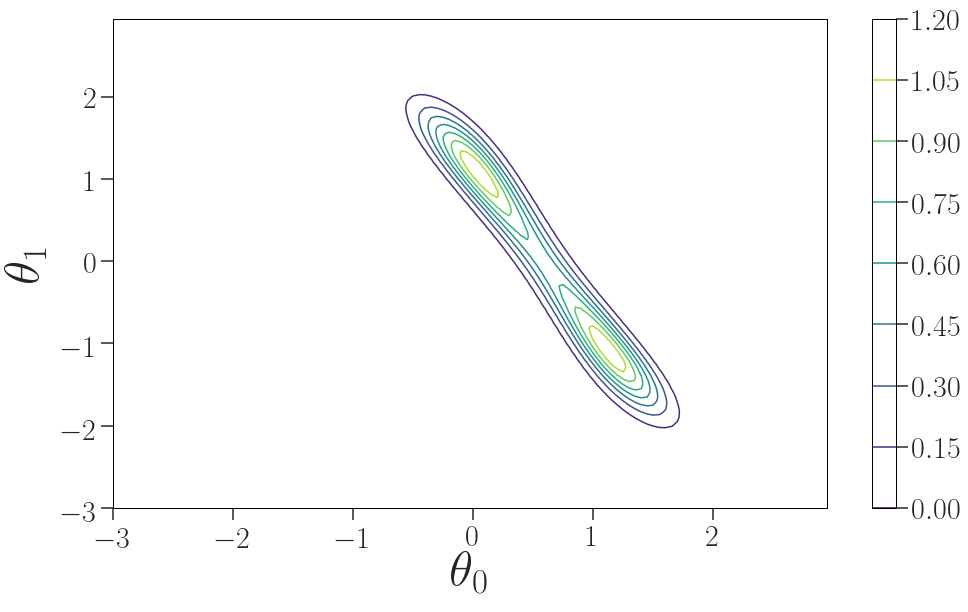

In [5]:
x_min = -3
x_max = 3
x_grid = np.arange(x_min, x_max, 0.05)
y_grid = np.arange(x_min, x_max, 0.05)
xx, yy = np.meshgrid(x_grid, y_grid, sparse=True)
n_data = 100

data = []
for i in range(n_data):
    k = np.random.rand()
    if k < 0.5:
        data.append(np.random.randn() * np.sqrt(2) + theta_optimum[0])
    else:
        data.append(np.random.randn() * np.sqrt(2) + theta_optimum[1] + theta_optimum[0])        
data = torch.from_numpy(np.array(data)).double()

f_opt = likelihood(data, torch.DoubleTensor(theta_optimum))

densities = np.asarray([likelihood(data, torch.DoubleTensor(np.array([x, y])), f_opt=f_opt)
                        for x in x_grid for y in y_grid])

densities = densities.reshape(x_grid.shape[0], y_grid.shape[0]).T

plt.contour(x_grid, y_grid, densities, 10, cmap="viridis")
plt.colorbar()
plt.xlabel(r"$\theta_0$",  fontsize=50)
plt.ylabel(r"$\theta_1$",  fontsize=50)

# SGLD

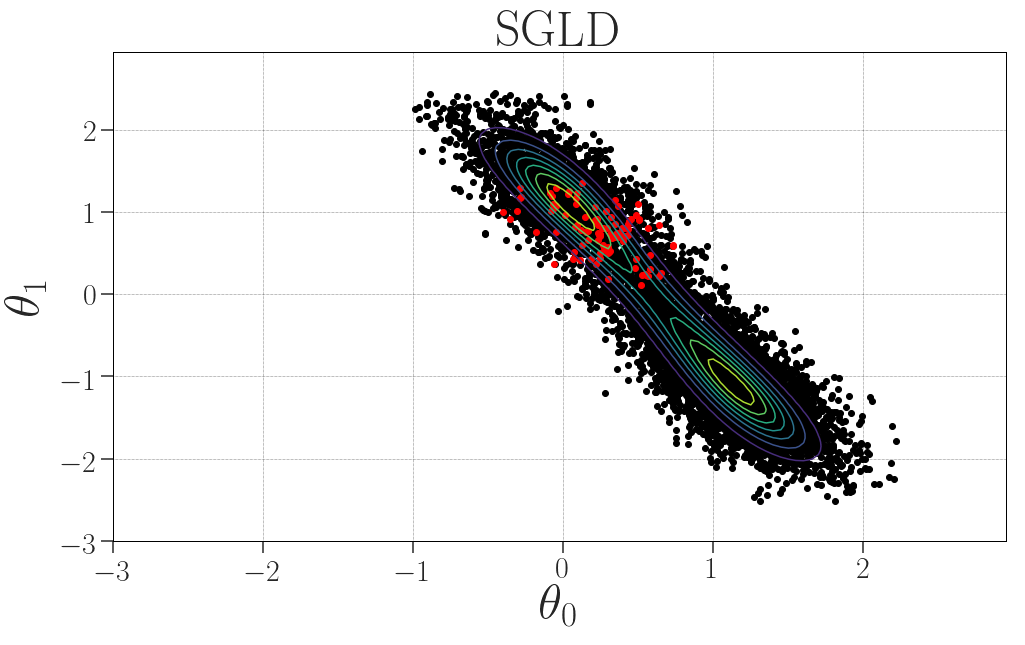

In [6]:
from pybnn.sampler import SGLD
import torch.utils.data as data_utils
from itertools import islice
from pybnn.util.infinite_dataloader import infinite_dataloader

theta = [torch.autograd.Variable(torch.DoubleTensor([0]), requires_grad=True),
        torch.autograd.Variable(torch.DoubleTensor([0]), requires_grad=True)]

n_burnin = 100
num_steps = n_burnin + 9900
batch_size = 10
sampler = SGLD(theta, lr=1e-2, scale_grad=data.size(0))

burnin_samples = []

samples = []

batch_generator  = infinite_dataloader(
            data_utils.DataLoader(
                data,
                batch_size=batch_size,
                shuffle=True
            ))

lr = []
sigma = []
for step, x_batch in islice(enumerate(batch_generator), num_steps):
    sampler.zero_grad()
    loss = nll(x_batch, theta)
    loss.backward()
    sampler.step()
    if step > n_burnin:
        samples.append([theta[0].data.numpy()[0], theta[1].data.numpy()[0]])
    else:
        burnin_samples.append([theta[0].data.numpy()[0], theta[1].data.numpy()[0]])

    sigma.append(sampler.state[theta[1]]["sigma"])
    
samples = np.array(samples)
burnin_samples = np.array(burnin_samples)

plt.contour(x_grid, y_grid, densities, 10, cmap="viridis")

plt.grid(True)
plt.scatter(samples[:, 0], samples[:, 1], color="k")
plt.scatter(burnin_samples[:, 0], burnin_samples[:, 1], color="r")
plt.title("SGLD",  fontsize=50)
plt.xlabel(r"$\theta_0$",  fontsize=50)
plt.ylabel(r"$\theta_1$",  fontsize=50)
plt.show()

# Preconditioned SGLD

(9899, 2)


Text(0, 0.5, '$\\theta_1$')

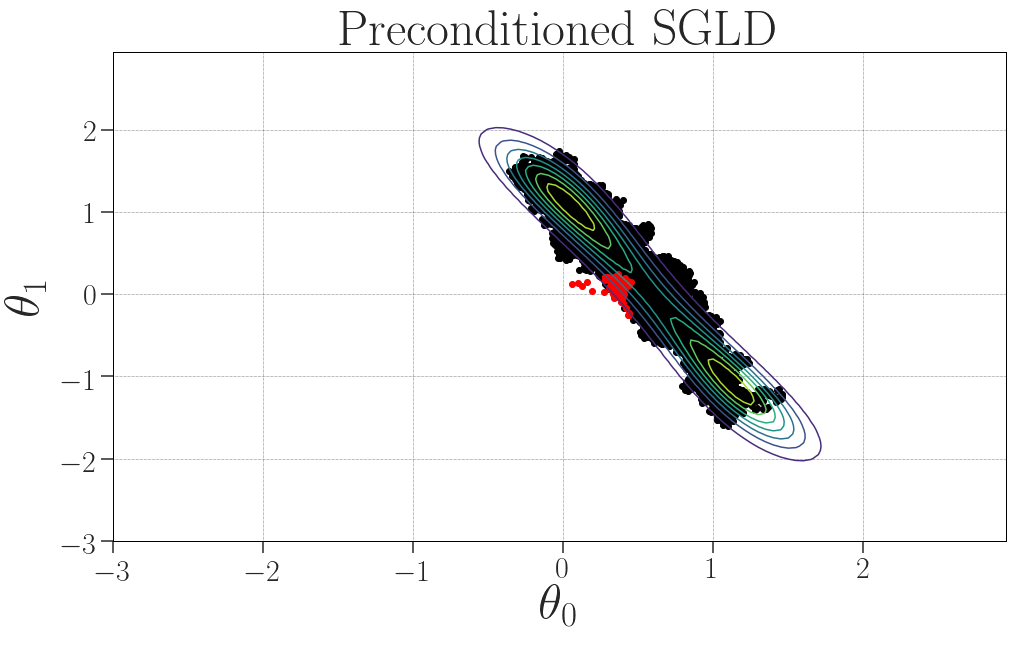

In [7]:
from pybnn.sampler.preconditioned_sgld import PreconditionedSGLD
import torch.utils.data as data_utils
from itertools import islice
from pybnn.util.infinite_dataloader import infinite_dataloader

theta = [torch.autograd.Variable(torch.DoubleTensor([0]), requires_grad=True),
        torch.autograd.Variable(torch.DoubleTensor([0]), requires_grad=True)]

n_burnin = 100
num_steps = n_burnin + 9900
batch_size = 10
sampler = PreconditionedSGLD(theta, lr=1e-2, num_train_points=data.size(0))

burnin_samples = []

samples = []

batch_generator  = infinite_dataloader(
            data_utils.DataLoader(
                data,
                batch_size=batch_size,
                shuffle=True
            ))

for step, x_batch in islice(enumerate(batch_generator), num_steps):
    sampler.zero_grad()
    loss = nll(x_batch, theta)
    loss.backward()
    sampler.step()
    if step > n_burnin:
        samples.append([theta[0].data.numpy()[0], theta[1].data.numpy()[0]])
    else:
        burnin_samples.append([theta[0].data.numpy()[0], theta[1].data.numpy()[0]])
    
samples = np.array(samples)
burnin_samples = np.array(burnin_samples)

print(samples.shape)

plt.contour(x_grid, y_grid, densities, 10, cmap="viridis")

plt.grid(True)
plt.scatter(samples[:, 0], samples[:, 1], color="k")
plt.scatter(burnin_samples[:, 0], burnin_samples[:, 1], color="r")
plt.title("Preconditioned SGLD",  fontsize=50)
plt.xlabel(r"$\theta_0$",  fontsize=50)
plt.ylabel(r"$\theta_1$",  fontsize=50)

# SGHMC

(9899, 2)


Text(0, 0.5, '$\\theta_1$')

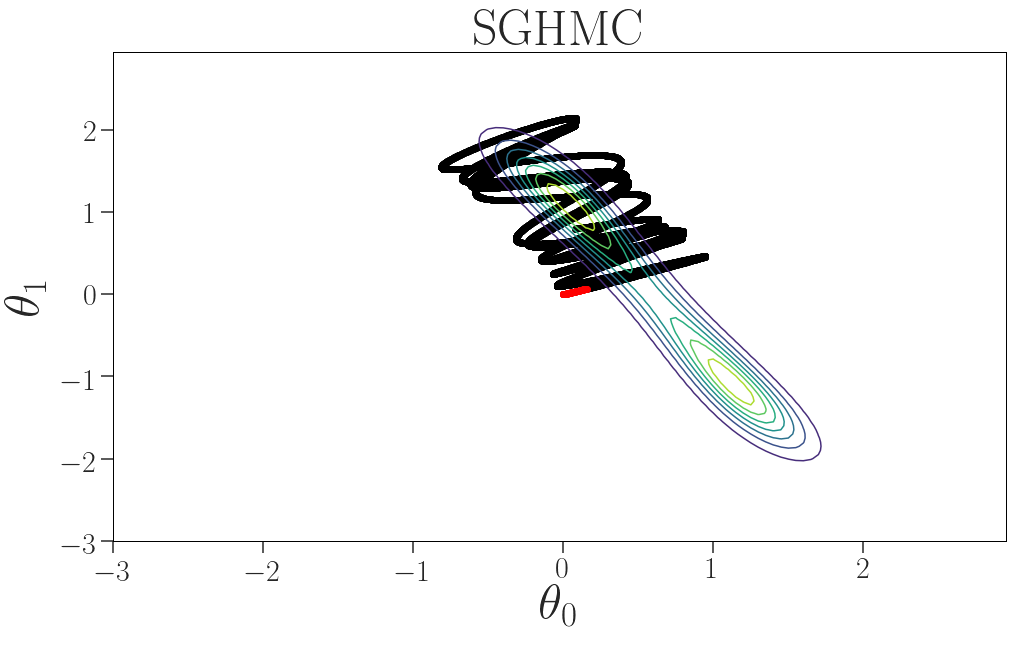

In [8]:
from pybnn.sampler.sghmc import SGHMC
import torch.utils.data as data_utils
from itertools import islice
from pybnn.util.infinite_dataloader import infinite_dataloader

theta = [torch.autograd.Variable(torch.DoubleTensor([0.0]), requires_grad=True),
        torch.autograd.Variable(torch.DoubleTensor([0.0]), requires_grad=True)]

n_burnin = 100
num_steps = n_burnin + 9900
batch_size = 10

sampler = SGHMC(theta, lr=np.float64(1e-2), scale_grad=data.size(0), mdecay=0.01)

burnin_samples = []

samples = []

batch_generator  = infinite_dataloader(
            data_utils.DataLoader(
                data,
                batch_size=batch_size,
                shuffle=True
            ))

for step, x_batch in islice(enumerate(batch_generator), num_steps):
    sampler.zero_grad()
    loss = nll(x_batch, theta)
    loss.backward()
    sampler.step()
    if step > n_burnin:
        samples.append([theta[0].data.numpy()[0], theta[1].data.numpy()[0]])
    else:
        burnin_samples.append([theta[0].data.numpy()[0], theta[1].data.numpy()[0]])
    
samples = np.array(samples)
burnin_samples = np.array(burnin_samples)

print(samples.shape)

plt.contour(x_grid, y_grid, densities, 10, cmap="viridis")

plt.scatter(samples[:, 0], samples[:, 1], color="k")
plt.scatter(burnin_samples[:, 0], burnin_samples[:, 1], color="r")
plt.title("SGHMC",  fontsize=50)
plt.xlabel(r"$\theta_0$",  fontsize=50)
plt.ylabel(r"$\theta_1$",  fontsize=50)

# Adaptive-SGHMC

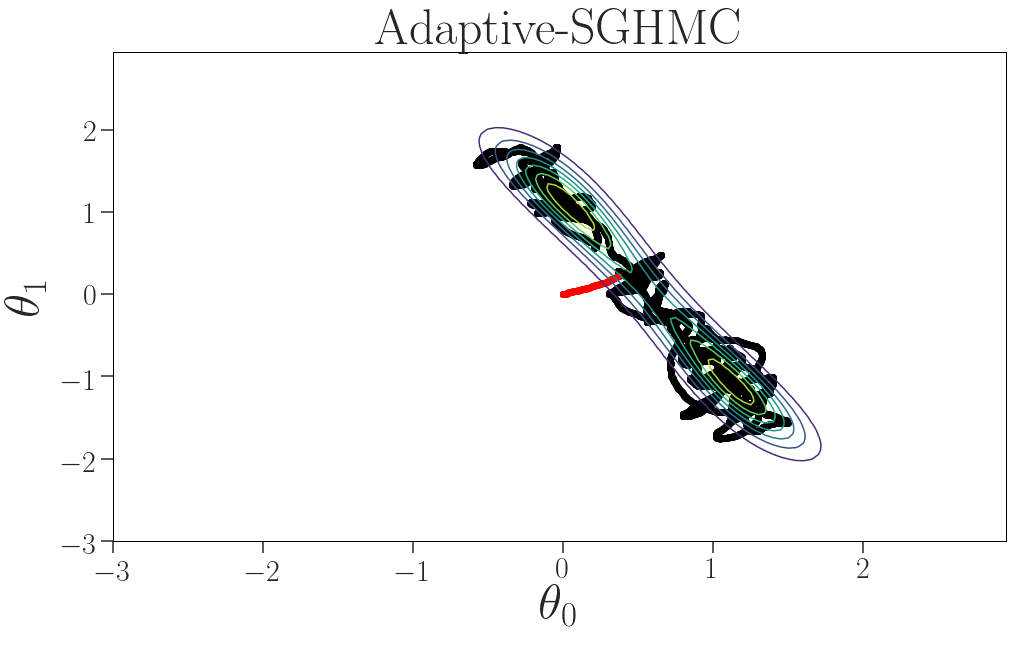

In [9]:
from pybnn.sampler import AdaptiveSGHMC
import torch.utils.data as data_utils
from copy import deepcopy
from itertools import islice
from pybnn.util.infinite_dataloader import infinite_dataloader

theta = [torch.autograd.Variable(torch.DoubleTensor([0.0]), requires_grad=True),
        torch.autograd.Variable(torch.DoubleTensor([0.0]), requires_grad=True)]

n_burnin = 100
num_steps = n_burnin + 9900
batch_size = 10
sampler = AdaptiveSGHMC(theta, num_burn_in_steps=n_burnin, lr=np.float64(1e-2), scale_grad=data.size(0), mdecay=0.01)

burnin_samples = []

samples = []

batch_generator  = infinite_dataloader(
            data_utils.DataLoader(
                data,
                batch_size=batch_size,
                shuffle=True
            ))


var_theta0 = []
var_theta1 = []

for step, x_batch in islice(enumerate(batch_generator), num_steps):
    sampler.zero_grad()
    loss = nll(x_batch, theta)
    loss.backward()
    sampler.step()
    if step > n_burnin:
        samples.append([theta[0].data.numpy()[0], theta[1].data.numpy()[0]])
    else:
        burnin_samples.append([theta[0].data.numpy()[0], theta[1].data.numpy()[0]])
    
        
    var_theta0.append(deepcopy(sampler.state[theta[0]]["v_hat"]))
    var_theta1.append(deepcopy(sampler.state[theta[1]]["v_hat"]))
    
samples = np.array(samples)
burnin_samples = np.array(burnin_samples)

plt.contour(x_grid, y_grid, densities, 10, cmap="viridis")

plt.scatter(samples[:, 0], samples[:, 1], color="k")

plt.scatter(burnin_samples[:, 0], burnin_samples[:, 1], color="r")
plt.title("Adaptive-SGHMC",  fontsize=50)
plt.xlabel(r"$\theta_0$",  fontsize=50)
plt.ylabel(r"$\theta_1$",  fontsize=50)

plt.show()